# Who wrote this? A Study for Authorship Attribution

"I ought to be thy Adam, but I am rather the fallen angel."

"Nothing is so painful to the human mind as a great and sudden change."

"It is the nature of truth in general, as of some ores in particular, to be richest when most superficial."

"The oldest and strongest emotion of mankind is fear, and the oldest and strongest kind of fear is fear of the unknown."

![alt text](img/shelley.jpg) ![alt text](img/poe.png) ![alt text](img/lovecraft.jpg)

Edgar Allan Poe, Mary Shelley, Howard Phillips Lovecraft

**Objective:**
Identify the writer of a sentence

**Data:**
For each writer a list of sentences from works of e.g. like Frankenstein, The Unparalleled Adventure of Hans Pfaall, The Call of Cthulhu

# Data Exploration and Preprocessing

In [197]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as plt
from os import path
import nltk
from nltk.stem import WordNetLemmatizer
import seaborn as sb
from functools import reduce, partial
from itertools import groupby
import operator
#TODO fix?
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# Utilities
identity = lambda x: x
first = lambda x: x[0]
second = lambda x: x[1]

def compose(*functions):
    """Returns a function as composition of fuctions: f,g,..,h -> f°g°..°h"""
    return reduce(lambda f, g: lambda x: f(g(x)),
                            functions,
                            identity)

# Return container objects instead of iterators
mapl = lambda f,xs: list(map(f,xs))
reversedl = compose(list, reversed)
rangel = compose(list, range)
filterl = lambda f,xs: list(filter(f,xs))

## Tokenization and Provisions

In [88]:
d = pd.read_csv('data/train.csv')
#execute only once to download resources
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
d['tokens'] = d.text.apply(nltk.word_tokenize)
d.head()

,id,text,author,tokens
0,id26305,"This process, however, afforded me no means of...",EAP,"[This, process, ,, however, ,, afforded, me, n..."
1,id17569,It never once occurred to me that the fumbling...,HPL,"[It, never, once, occurred, to, me, that, the,..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"[In, his, left, hand, was, a, gold, snuff, box..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[How, lovely, is, spring, As, we, looked, from..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"[Finding, nothing, else, ,, not, even, gold, ,..."


In [89]:
# Further provisions of token preprocessing
# Remove heading apostrophes as their occurrence is highly unbalanced among writer's corpora (might be due to publishing reasons)
filter_heading_apostrophes = compose(list,
                                     partial(filter, lambda tokens: "'"!=tokens[0][0]))

transform_lower_case = compose(list,
                               partial(map, lambda token: token.lower()))

d.tokens = d.tokens.apply(compose(filter_heading_apostrophes,
                                  transform_lower_case))

### Vocabulary in the Corpus

In [90]:
tokenList = partial(reduce, operator.concat)
frequencies = lambda l: sorted([(k, len(list(v))) for k,v in groupby(sorted(l))],
                               key=second, reverse=True)

allTokens = {}
allTokens['corpus'] = tokenList(d.tokens)
vocabulary = {}
vocabulary['corpus'] = set(allTokens['corpus'])
tokenFreq = {}
tokenFreq['corpus'] = frequencies(allTokens['corpus'])

#### Whole Corpus and Writers' Corpora

Frequencies in the writers corpora of the  15 most common tokens


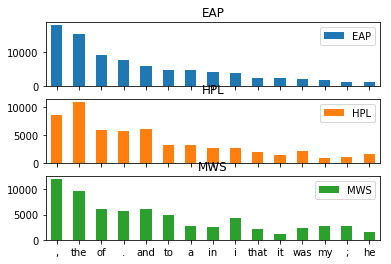

In [181]:
first_n_most_frequent_tokens = lambda n: mapl(first, tokenFreq['corpus'][:n])
writers = ['EAP', 'HPL', 'MWS']
corpora = writers # + ['corpus']

def get_token_freq(tokens, corpus):
    dict_freq = dict(tokenFreq[corpus])
    return {k: dict_freq[k] for k in tokens}

n_w = 15

most_freq_tokens = pd.DataFrame.from_dict(
    dict(zip(corpora,
             map(partial(get_token_freq, first_n_most_frequent_tokens(n_w)),
                 corpora)))).sort_values(by=['EAP'], ascending=False)

print('Frequencies in the writers corpora of the ', n_w, 'most common tokens')
most_freq_tokens.plot.bar(rot=0, subplots=True);

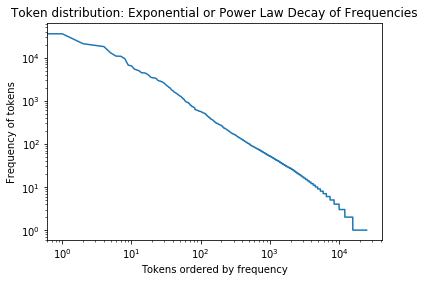

In [182]:
plt.loglog(rangel(len(tokenFreq['corpus'])),
           mapl(second, tokenFreq['corpus']));
plt.title('Token distribution: Exponential or Power Law Decay of Frequencies');
plt.xlabel('Tokens ordered by frequency'); plt.ylabel('Frequency of tokens');

In [186]:
singletons = filterl(compose(lambda x: x==1, second), tokenFreq['corpus'])
print("Number of tokens occuring only once", len(singletons))
print("Samples of rare words", mapl(first, singletons[:30]))

Number of tokens occuring only once 9307
Samples of rare words ['a.d', 'a.d.', 'a.m', 'aaem', 'ab', 'abaft', 'abased', 'abasement', 'abashed', 'abashment', 'abated', 'abating', 'abbeys', 'abbé', 'abdicated', 'abdications', 'abdomen', 'aberrancy', 'aberration', 'abide', 'abijah', 'abjure', 'ablaze', 'ably', 'abolished', 'aboriginal', 'abortion', 'abounded', 'aboundingly', 'absconded']


# Simple Model on Common Words
**Approach:** Naive Bayes classifier on the frequency of common words in a sentence

In [94]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing

## Vectorization

In [96]:
filter_by_set = lambda coll: compose(list,
                                     partial(filter, lambda x: x in coll))

# Returns the frequencies of the vocs in the tokens as sparse matrix
frequencies_in_tokens = lambda tokens, vocabulary: dv.fit_transform(
                                                    map(compose(dict,
                                                            frequencies,
                                                            filter_by_set(vocabulary)),
                                                        tokens))

## Model Construction

In [194]:
number_common_words = 200
Y = d.author
X = frequencies_in_tokens(d.tokens,
                          first_n_most_frequent_tokens(number_common_words))
model = MultinomialNB().fit(X,Y)
Y_pred = model.predict(X)
print('In-sample Results\n  Classification Report\n', classification_report(Y, Y_pred))
print('  Confusion Matrix')
pd.DataFrame(confusion_matrix(Y, Y_pred, labels=writers), columns=writers, index=writers)

In-sample Results
  Classification Report
               precision    recall  f1-score   support

         EAP       0.67      0.68      0.67      7900
         HPL       0.59      0.66      0.62      5635
         MWS       0.67      0.59      0.63      6044

   micro avg       0.65      0.65      0.65     19579
   macro avg       0.64      0.64      0.64     19579
weighted avg       0.65      0.65      0.65     19579

  Confusion Matrix


,EAP,HPL,MWS
EAP,5350,1414,1136
HPL,1307,3701,627
MWS,1325,1135,3584


## Model Evaluation

In [195]:
precision = lambda x, y: sum(x == y) / len(x)

def classifier_assessment(model_class, X, Y) -> None:
    return {'in-sample-precision': precision(Y, model_class.fit(X,Y).predict(X)),
            'out-of-sample-precision': np.mean(cross_val_score(model_class, X, Y, cv=8))}

classifier_assessment(model, X, Y)

{'in-sample-precision': 0.6453342867357883,
 'out-of-sample-precision': 0.6388973395539028}

## Model Variations
### Sensitivity to Number of Common Words

In [98]:
for n in [5, 10, 50, 100, 200, 400, 600, 1000, 1500, 2000, 5000, 10000]:
    X = frequencies_in_tokens(d.tokens, first_n_most_frequent_tokens(n))
    print(n, classifier_assessment(MultinomialNB(), X, Y))
    
#TODO: add plot

5 {'in-sample-precision': 0.45559017314469585, 'out-of-sample-precision': 0.45605126059258444}
10 {'in-sample-precision': 0.4691250829970887, 'out-of-sample-precision': 0.4692259731151678}
50 {'in-sample-precision': 0.5732672761632361, 'out-of-sample-precision': 0.5711207508283209}
100 {'in-sample-precision': 0.5990091424485418, 'out-of-sample-precision': 0.5963534444116483}
200 {'in-sample-precision': 0.6453342867357883, 'out-of-sample-precision': 0.6388973395539028}
400 {'in-sample-precision': 0.6934981357576996, 'out-of-sample-precision': 0.6860909748901042}
600 {'in-sample-precision': 0.7227641861177793, 'out-of-sample-precision': 0.7119357667044304}
1000 {'in-sample-precision': 0.7562183972623729, 'out-of-sample-precision': 0.7413032593343052}
1500 {'in-sample-precision': 0.7820113386791971, 'out-of-sample-precision': 0.7619378174824729}
2000 {'in-sample-precision': 0.8008069870779917, 'out-of-sample-precision': 0.7786915094976463}
5000 {'in-sample-precision': 0.8575514581950049, 

Take no more than 200 words as from then on content bearings words appear, e.g. character names like Raymond.

### Sensitivity towards Model Class

In [201]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

X = frequencies_in_tokens(d.tokens,
                          first_n_most_frequent_tokens(number_common_words))

model_classes = {'SVM-one-vs-rest': LinearSVC(),
                 'RandomForest': RandomForestClassifier(),
                 'GradientBoosting': GradientBoostingClassifier(n_estimators= 100, max_depth = 5),
                 'Nearest-Centroid': NearestCentroid(),
                 '10-Nearest-Neibors': KNeighborsClassifier(n_neighbors=10),
                 '20-Nearest-Neibors': KNeighborsClassifier(n_neighbors=10)}

for m in model_classes.keys():
    print(m, '\n', classifier_assessment(model_classes[m], X, Y))

SVM-one-vs-rest 
 {'in-sample-precision': 0.669084222891874, 'out-of-sample-precision': 0.658156100141861}
RandomForest 
 {'in-sample-precision': 0.9843710097553501, 'out-of-sample-precision': 0.5931349869206175}
GradientBoosting 
 {'in-sample-precision': 0.7260840696664794, 'out-of-sample-precision': 0.6624446285905089}


# Multinomial Bayes Classifier and its Interpretation
## Model
In an multinomial model the random variable of feature occurrence counts $X = (X_1, \ldots, X_n)$ has the *distribution conditional on class* $Y$

$$ P_k \left\{ X_1 = x_1,\ldots, X_n =x_n | Y \right\} = \frac{m!}{x_1!\ldots x_n!} \prod_{k=1\dots n} p_{k|y}^{x_k}$$

**Interpretation:** Using this model implies that a writer $y$ builds a sentence of length $m$ by picking $m$-times from the set of common words where each common word $k$ appears with probability $p_{k|y}$.

## Estimation of Model Parameters
Sklearn *estimates* these probabilities (recalling source code MultinomialNB._count) by the relative frequencies in the corpus for a class $y$

\begin{align}
 \hat p_{k|y} & = \frac{c_{k,y}}{c_y} \\
      c_{k,y} & = \sum_{\omega| Y(\omega) = y} X_k(\omega) + \alpha \\
      c_y     & = \sum_k c_{k|y}
\end{align}
The parameter $\alpha$ regularizes.

**Interpretation:**
* The writer picks randomly a word from all the words he has ever written 
* puts it back and repeats $m$-times

![alt text](img/um.jpg)

Note: This is a portfolio approach in which the occurrences among single observations are irrelevant, e.g. observing two times a frequency of 2 yielding the same as 0 and 4 each one time.

## Model Application
The calibrated Bayes model attributes observation $x$ to the probability being of class $y$ 
$$P\{ Y=y | X=x \} = \frac{P\{Y=y\} P\{X=x|Y=y\}} {P\{X=x\}} $$

With evidence the same for all classes a Bayes classifier would attribute the class with the highest probability

$$\text{classifier:} ~~ x \longrightarrow \text{argmax}_{y} P\{Y=y\} P\{X=x | Y=y\}$$

The latter returns the same when transforming the probabilities in the following way

\begin{align}
 & P\{ Y=y \} P\{ X=x | Y=y \} \\
 & = P\{ Y=y \}  \frac{m!}{x_1!\ldots x_n!} \prod_{k=1\dots n} p_{k|y}^{x_k} \\
 & \approx P\{ Y=y \} \prod_{k=1\dots n} p_{k|y}^{x_k} \\
 & \approx \log P\{ Y=y \} + x_k \log p_{k|y}
\end{align}

## Features with high predictive power
The higher conditional probability of a word given an author $\log p_{k|y} $, the higher is its influence on the classifier
Ignoring the relative even priors, the 

In [101]:
common_words = first_n_most_frequent_tokens(n)
log_prob = dict(zip(model.classes_,
             map(lambda xs: list(sorted(zip(common_words, xs),
                                 key=lambda x: x[1], reverse=True)),
                 model.feature_log_prob_)))

for w in writers:
    print(w)
    print('Highest Log prob')
    print(log_prob[w][:5])
    print('Lowest')
    print(log_prob[w][-5:])

EAP
Highest Log prob
[(',', -2.131595505653239), ('thing', -2.2931620779952517), ('where', -2.805213123849642), ('the', -2.957860085869676), ('he', -3.2527969089656104)]
Lowest
[('most', -7.9557218368274984), ('house', -8.122775921490664), ('they', -8.911233281854935), ('light', -9.60438046241488), ('once', -11.906965555408926)]
HPL
Highest Log prob
[('thing', -2.250415344817034), (',', -2.4926255587205084), ('he', -2.834167721975522), ('where', -2.876363836096308), ('the', -2.9004238456752507)]
Lowest
[('three', -7.994699762782565), ('come', -8.777459102032196), ('will', -8.910990494656719), ('most', -9.470606282592142), ('once', -10.451435535603869)]
MWS
Highest Log prob
[(',', -2.3123414291337845), ('thing', -2.533287496303963), ('where', -2.986575127557769), ('he', -2.9890219112594956), ('the', -3.0583298040129883)]
Lowest
[('love', -7.880187966248355), ('death', -7.924639728819189), ('know', -8.412992496733121), ('few', -8.412992496733121), ('day', -11.70882936273745)]


###  Enhance Features with Statistics
Add to the above frequencies of common words the following statistics
 * sentence length
 
The stastistics alone has predictive power. Find a ways for incorporation into above model approaches.

In [102]:
sentence_lengths = np.array(list(map(len, d.tokens))).reshape(-1, 1)
classifier_assessment(MultinomialNB(), sentence_lengths, Y)

{'in-sample-precision': 0.40349353899586293,
 'out-of-sample-precision': 0.4034935578860775}

In [103]:
#X = frequencies_in_tokens(d.tokens, first_n_most_frequent_tokens(n))
type(X)

scipy.sparse.csr.csr_matrix

##  Questions
 * Why does the usual tf-idf approach not work for author attribution?
 * Explain why the in-sample and ou-of-sample error for random forest are so significant

## Outlook

Character Level
 * n-grams 
   * eg. 3-grams |No_| |o_o| |_on| |one|
 * punctuation
   * eg. frequency of commas, semicolons, periods, quotation-marks

Lexical Level
 * word occurences
   * frequences
   * indicators
 * word n-grams

Syntactical Level
 * part of speech
   word classes as lexical items: noun, verb, adjective, adverb, pronoun, preposition, conjunction, interjection, numeral, article, determiner
 * part of sentence
   consituents as lexical items: subject, predicate, direct/indirect object, modifier, abvervial,
 * sentence 

Semantic
 *


In [104]:
# In the above multinomial model the use of common words in a sentence happens in the following way
# A writer y picks a common words x_j with probability p_j
#  
# https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/naive_bayes.py#L630